## 07 Testing Strategies in Practice.

In this notebook I want to use the functions and tools defined in the previous chapters and collected in the `Utils.py` file to test investing strategies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use('ggplot')

In [2]:
from Utils import *

#### 1. Define and explore the assets to include in portfolio.

I want to build a simple portfolio of four assets.
- `ITPS` seeks to track the *Bloomberg US Government Inflation-Linked Bond* index. This index tracks US Treasury Inflation-Protected Securities (TIPS). The ETF replicates the performance of the underlying index by **sampling** technique (buying a selection of the most relevant index constituents). The interest income (coupons) in the ETF is accumulated and reinvested in the ETF. TER (*Total Expense Ratio*) 0.10%.
- `EM710` seeks to track the *Bloomberg Euro Treasury 50bn 7-10 Year Bond* index. This index tracks Euro denominated government bonds issued by members of the eurozone. Time to maturity: 7-10 years. Rating: Investment Grade. The ETF replicates the performance of the underlying index by **full replication** (buying all the index constituents). The interest income (coupons) in the ETF is accumulated and reinvested in the ETF. TER 0.15%.
- `CSSPX` seeks to track the *S&P 500®* index. This index tracks the 500 largest US stocks. The ETF replicates the performance of the underlying index by **full replication**. The dividends in the ETF are accumulated and reinvested in the ETF. TER 0.07%.
- `PHAU` is an ETC (*Exchange Traded Commodities*) that replicates the performance of the underlying index with a collateralised debt obligation which is **backed by physical holdings** of the precious metal. TER 0.39%. ETCs allow compensating losses from other assets before taxation on gains. This does not apply to ETFs.

In [3]:
# list of asset tickers
tickers = ['ITPS','EM710','CSSPX','PHAU']

In [4]:
# create a list of pd.Series with each ticker's historical prices
data = [] # empty list of the historical price series
for tick in tickers:
    data.append(prices(ticker=tick, source='yf')) # using 'yf' as data source

# create the DataFrame with all historical prices of tickers in portfolio
portfolio_prices = portfolio_prices(data)

I want to see the performace of each asset at least in the last 15 years. For this I use the function `portfolio_performance` calculating the main performance indicators from a pd.Series of either Portfolio values or single asset values.

In [5]:
performance = []
for tick in tickers:
    performance.append(portfolio_performance(portfolio_prices[tick]))
performance = pd.concat(performance, axis=1)
performance.columns = tickers
print('Past series length: ', 
      round((portfolio_prices.index[-1] - portfolio_prices.index[0]) / pd.to_timedelta('365.25D'), 2), 'years \n')
print(performance.round(3))

Past series length:  14.93 years 

                    ITPS  EM710  CSSPX   PHAU
Total_Return       0.633  0.380  6.043  1.799
Annual_Return      0.033  0.022  0.140  0.071
Annual_Volatility  0.097  0.056  0.163  0.145
Sharpe             0.346  0.391  0.855  0.491


For all assets annual volatility is greater than annual returns, implying a Sharpe Ratio < 1.

In order to minimize the risk of my portfolio, I want to see that the assets have no or little correlation:

In [6]:
portfolio_prices.pct_change().dropna().corr()

,ITPS,EM710,CSSPX,PHAU
ITPS,1.000000,0.234751,0.160079,0.319608
EM710,0.234751,1.000000,0.022113,0.190291
CSSPX,0.160079,0.022113,1.000000,0.035778
PHAU,0.319608,0.190291,0.035778,1.000000


`CSSPX` is the asset less correlated with the others. The remaining three assets seem to have some low correlation between them (< 0.35).

Another feature I want to look at is the depth of the worst 5 **drawdowns** of each asset.

In [7]:
drawdowns=[]
for tick in tickers:
    drawdowns.append(drawdown_metrics(portfolio_prices[tick])['drawdown'].head())

drawdowns = pd.concat(drawdowns, axis=1)
drawdowns.columns = tickers
drawdowns

,ITPS,EM710,CSSPX,PHAU
0,-0.199941,-0.224812,-0.335635,-0.372426
1,-0.159086,-0.096999,-0.232641,-0.184366
2,-0.151775,-0.068824,-0.201559,-0.144830
3,-0.137548,-0.059875,-0.190166,-0.135725
4,-0.109647,-0.057464,-0.170035,-0.130800


The max drawdowns of each asset ranged from about -20% to -37%, confirming the risk associated to each individual asset.

It can be interesting to visualize how each asset drawdowns happend over time.

In [8]:
# Calculating the rolling max each asset using .rolling().max() over a 252 days window
roll_max = (portfolio_prices).rolling(min_periods=1, window=252).max()

# Calculating the daily draw-down from rolling max per each asset
daily_drawdown = (portfolio_prices)/roll_max - 1

# Calculating the rollling max daily draw-down over a 252 days window per each asset
max_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=252).min()

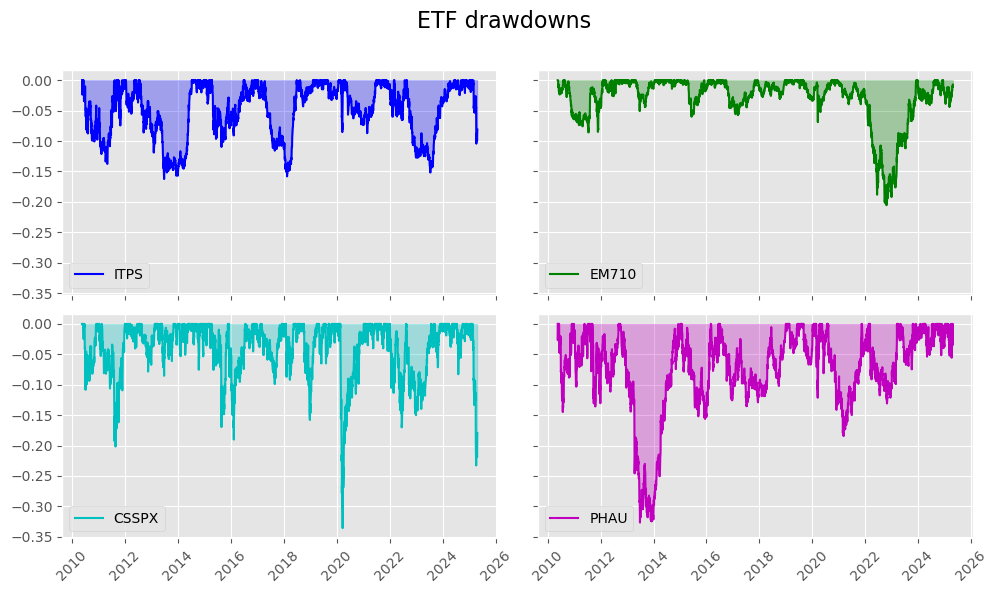

In [9]:
# Create a figure and an array of axes: 4 rows, 1 column with shared y axis
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,6))
ax = ax.flatten()
colors = ['b','g','c','m']
fig.suptitle('ETF drawdowns', fontsize=16)

for i, tick in enumerate(tickers):
    # Plot the rolling max of asset Values using .rolling().max() over a 250 days window
    ax[i].plot(daily_drawdown[tick].index, daily_drawdown[tick],
               color = colors[i], label=tick)
    ax[i].fill_between(daily_drawdown[tick].index, daily_drawdown[tick], color = colors[i], alpha=0.3)
    ax[i].legend()

# Rotate xticks by 45° for the bottom graphs (axes 2 and 3 in the flattened array)
for i in [2, 3]:
    ax[i].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

The worst drawdown periods of the assets happened over different time spans, which is consistent with the low correlation among assets calculated before.

Now I want to see what are the weights to give to each asset in my portfolio to 
- minimize volatility and depth of drawdown periods 
- maximize the returns. 

To do so I need to backtest a portfolio behavior given the inital weights of each asset.

#### 2. Backtesting different portfolio weights.

I want to test different portfolio allocations by changing how much of my portfolio is invested in CSSPX (between 10% and 50%). For each allocation, I’ll split the rest of my money evenly among the other assets. I'll write the function `generate_portfolio_weights()` to execute these weight allocations.

Then, I'll backtest each of these portfolios using historical price data to see:

- how well they performed (returns), and

- how badly they fell during tough times (drawdowns).

At the end, I’ll pick the portfolio that gives the best balance between growth and risk.

In [10]:
def generate_portfolio_weights(assets, target_asset, min_weight=0.1, max_weight=0.5, steps=10):
    """
    Generate a matrix of portfolio weight vectors by varying the weight of a target asset
    within a specified range, while distributing the remaining weight equally across other assets.

    Parameters:
        assets (list of str): List of asset names or tickers.
        target_asset (str): The asset whose weight will be varied.
        min_weight (float): Minimum weight for the target asset (default is 0.1).
        max_weight (float): Maximum weight for the target asset (default is 0.5).
        steps (int): Number of evenly spaced weight values to generate between min and max (default is 10).

    Returns:
        np.ndarray: A 2D array where each row represents a portfolio weight vector.
    """
    
    if target_asset not in assets:
        raise ValueError("Target asset must be in assets.")

    weights_matrix = []
    target_index = assets.index(target_asset)
    other_indices = [i for i in range(len(assets)) if i != target_index]

    for w in np.linspace(min_weight, max_weight, steps):
        weights = np.zeros(len(assets))
        weights[target_index] = w
        remaining_weight = 1 - w
        for idx in other_indices:
            weights[idx] = remaining_weight / len(other_indices)
        weights_matrix.append(weights)

    return np.array(weights_matrix)

In [11]:
weights_matrix = generate_portfolio_weights(assets=tickers, target_asset='CSSPX', 
                                            min_weight=0.15, max_weight=0.5, steps=40)
weights_matrix[:5]

array([[0.28333333, 0.28333333, 0.15      , 0.28333333],
       [0.28034188, 0.28034188, 0.15897436, 0.28034188],
       [0.27735043, 0.27735043, 0.16794872, 0.27735043],
       [0.27435897, 0.27435897, 0.17692308, 0.27435897],
       [0.27136752, 0.27136752, 0.18589744, 0.27136752]])

I test all these portfolios with different asset weights, using a **rebalance strategy** every 252 trading days.

In [12]:
results = []
for weights in weights_matrix:
    portfolio = backtest_portfolio(portfolio_prices, weights, rebalance=True).Portfolio
    pf_returns = portfolio_performance(portfolio).Annual_Return
    pf_volatility = portfolio_performance(portfolio).Annual_Volatility
    pf_sharpe = portfolio_performance(portfolio).Sharpe
    pf_max_dd = drawdown_metrics(portfolio)['drawdown'].head(1)
    
    results.append({
            'weights': np.round(weights,3),
            'annual_return': pf_returns,
            'volatility': pf_volatility,
            'sharpe_ratio': pf_sharpe,
            'max_drawdown': pf_max_dd[0]
        })

results_df = pd.DataFrame(results)

I want to see only the porfolios with **Sharpe Ratios > 1** and **max drawdowns** in my risk tolerance range between **14.5% and 15.5%**:

In [13]:
results_df[(results_df['sharpe_ratio']> 1) & 
           (results_df['max_drawdown'] > -0.155) & (results_df['max_drawdown'] < -0.145)]

,weights,annual_return,volatility,sharpe_ratio,max_drawdown
18,"[0.229, 0.229, 0.312, 0.229]",0.076487,0.075207,1.017017,-0.146446
19,"[0.226, 0.226, 0.321, 0.226]",0.077351,0.075814,1.020274,-0.148536
20,"[0.224, 0.224, 0.329, 0.224]",0.078214,0.076447,1.023110,-0.150624
21,"[0.221, 0.221, 0.338, 0.221]",0.079074,0.077105,1.025541,-0.152711
22,"[0.218, 0.218, 0.347, 0.218]",0.079933,0.077788,1.027583,-0.154795


The portfolio with weights `[0.221, 0.221, 0.338, 0.221]` showed a Sharpe Ratio >1 and a max drawdown acceptable for my risk tolerance (< 15.5%).

The plot of each portfolio return vs. risk colored by Sharpe Ratio at varying CSSPX weights is shown below:

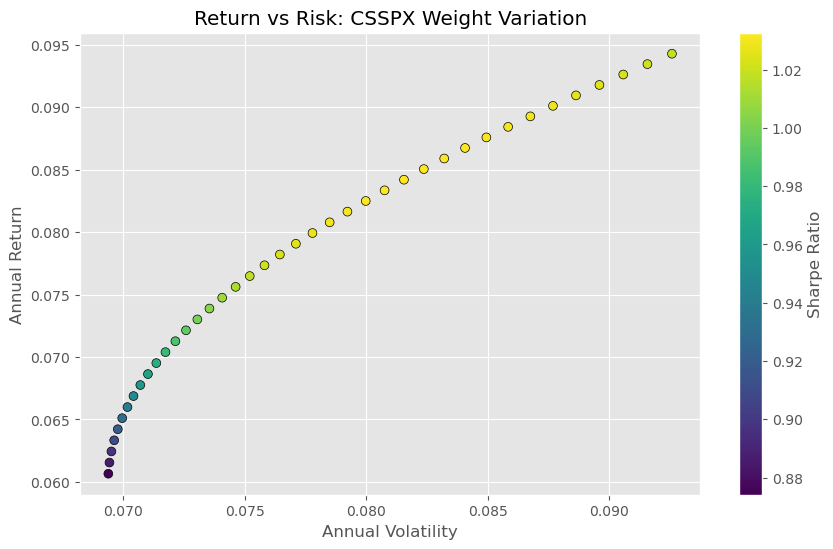

In [14]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    results_df.volatility,
    results_df.annual_return,
    c=results_df.sharpe_ratio,  # color by Sharpe ratio
    cmap='viridis',
    edgecolor='k',
    s=40
)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.title('Return vs Risk: CSSPX Weight Variation')
plt.grid(True)
plt.show()

Here is the plot of Portfolio value over time taking the weights vector `[0.221, 0.221, 0.338, 0.221]` satisfying my desired performance and risk tolerance:

1 Euro invested in this strategy would be worth 3.12 Euros today


<Axes: title={'center': 'Portfolio Normalized Value over time'}, xlabel='Date', ylabel='Normalized Value'>

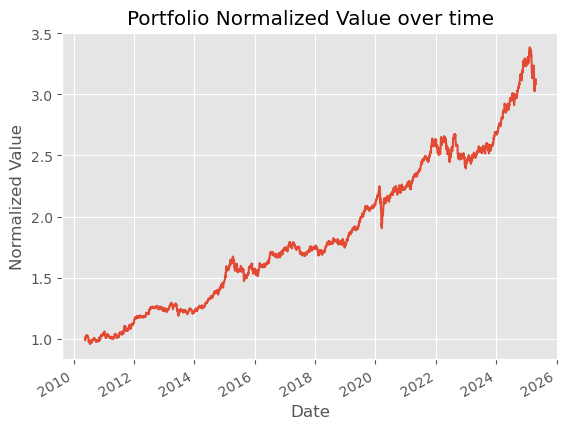

In [15]:
pf_values = backtest_portfolio(portfolio_prices, weights_matrix[21], rebalance=True).Portfolio
print('1 Euro invested in this strategy would be worth', pf_values.iloc[-1].round(2), 'Euros today')
pf_values.plot(title='Portfolio Normalized Value over time', ylabel='Normalized Value')

Here the table with the summary of the 10 worst drawdowns of this strategy:

In [16]:
drawdowns = drawdown_metrics(pf_values)
drawdowns['duration'] = drawdowns['valley'] - drawdowns['start']
drawdowns['recovery_time'] = drawdowns['end'] - drawdowns['valley']
drawdowns['total_lenght'] = drawdowns['end'] - drawdowns['start']
drawdowns

,drawdown,start,valley,end,duration,recovery_time,total_lenght
0,-0.152711,2020-02-20,2020-03-18,2020-09-02,27 days,168 days,195 days
1,-0.118456,2015-04-16,2015-08-24,2016-07-01,130 days,312 days,442 days
2,-0.106246,2025-02-11,2025-04-09,NaT,57 days,NaT,NaT
3,-0.105704,2022-08-17,2022-12-30,2023-12-15,135 days,350 days,485 days
4,-0.082072,2013-03-28,2013-06-24,2014-05-23,88 days,333 days,421 days
5,-0.078514,2022-04-13,2022-06-16,2022-08-16,64 days,61 days,125 days
6,-0.070388,2010-06-08,2010-07-19,2010-11-30,41 days,134 days,175 days
7,-0.065739,2017-03-03,2017-08-29,2018-06-14,179 days,289 days,468 days
8,-0.057917,2011-01-12,2011-04-12,2011-08-22,90 days,132 days,222 days
9,-0.051376,2021-11-22,2022-02-04,2022-03-04,74 days,28 days,102 days


#### 3. Creating a reusable plot for portfolio performance

I’m writing this function to easily visualize the relationship between annual return and annual volatility for different portfolios. It will help me quickly assess the results of backtests from various strategies or alternative backtesting functions I might use from `Utils.py`.

In [17]:
def plot_risk_return(df):
    """
    Plot annual return vs. annual volatility of portfolios.

    Generates a scatter plot where each point represents a portfolio,
    with color indicating the Sharpe ratio. Assumes the input DataFrame
    contains 'annual_return', 'volatility', and 'sharpe_ratio' columns.

    Parameters:
        df (pd.DataFrame): DataFrame containing portfolio performance metrics.
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df.volatility,
        df.annual_return,
        c=df.sharpe_ratio,  # color by Sharpe ratio
        cmap='viridis',
        edgecolor='k',
        s=40
    )
    plt.colorbar(scatter, label='Sharpe Ratio')
    plt.xlabel('Annual Volatility')
    plt.ylabel('Annual Return')
    plt.title('Return vs Risk Across Portfolio Weights')
    plt.grid(True)
    plt.show()


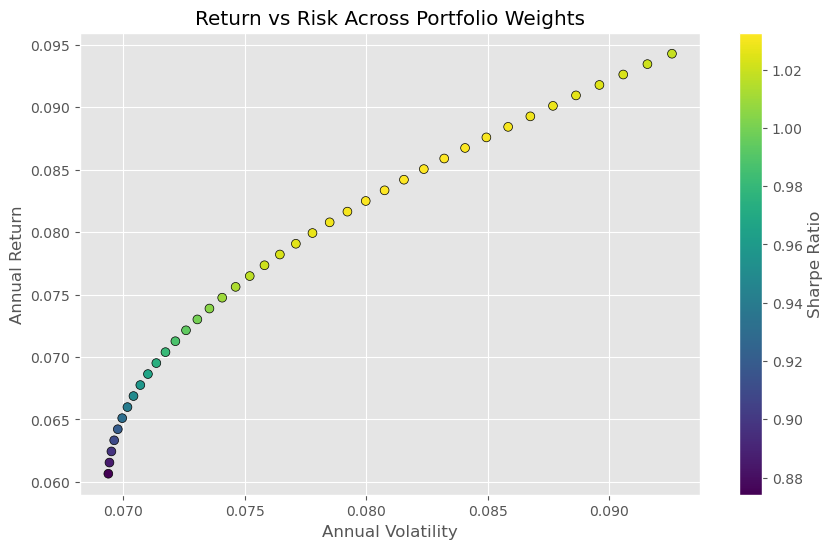

In [18]:
# testing the plot_risk_return function
plot_risk_return(results_df)

#### 4. Exploring a *Buy-and-Hold* Strategy Within Risk Limits

I’m testing different initial asset allocations to see which ones would be suitable for a buy-and-hold strategy. My goal is to identify portfolios that achieve a **Sharpe Ratio above 1**, while keeping the **maximum drawdown** within my acceptable range of **14.5%** to **15.5%**.

I already have the `weights_matrix` from Section 2. Now, I repeat the same steps as before, but this time I set the `rebalance=False` argument in the `backtest_portfolio()` function.

In [19]:
results = []
for weights in weights_matrix:
    portfolio = backtest_portfolio(portfolio_prices, weights, rebalance=False).Portfolio
    pf_returns = portfolio_performance(portfolio).Annual_Return
    pf_volatility = portfolio_performance(portfolio).Annual_Volatility
    pf_sharpe = portfolio_performance(portfolio).Sharpe
    pf_max_dd = drawdown_metrics(portfolio)['drawdown'].head(1)
    
    results.append({
            'weights': np.round(weights,3),
            'annual_return': pf_returns,
            'volatility': pf_volatility,
            'sharpe_ratio': pf_sharpe,
            'max_drawdown': pf_max_dd[0]
        })

results_df = pd.DataFrame(results)

In [20]:
results_df[(results_df['sharpe_ratio']> 1) & 
           (results_df['max_drawdown'] > -0.155) & (results_df['max_drawdown'] < -0.145) ]

,weights,annual_return,volatility,sharpe_ratio,max_drawdown


When searching for portfolios with **Sharpe Ratios > 1** and **max drawdowns** between **14.5%** and **15.5%**, I found that none of the tested allocations met both criteria. As a result, I’ve decided not to pursue a *buy-and-hold* strategy.

#### 5. Finding the Minimum Capital for Acceptable Portfolio Performance 

In this step, I test rebalanced portfolios by gradually increasing the **initial capital** until I find the minimum amount that allows at least one portfolio to meet my performance criteria:

- **Sharpe Ratio > 1**

- **Max Drawdown** between **-15.5%** and **-14.5%**

This method is necessary because the backtest is based on **discrete shares** — and when capital is too low, it's impossible to allocate weights precisely, which can lead to poor or misleading performance metrics. Increasing capital allows the allocation to better reflect the target weights and improves accuracy.

To perform these simulations efficiently, I used the `backtest_vect()` function — a **vectorized** version of the backtest logic that runs much faster than `backtest_sim()` due to its use of optimized array operations rather than iterative loops.

**Note.** I start from `initial_capital = 100_000` just to show the idea behind this approach and avoid too many iterations before finding the minimum `initial_capital`. But I could have started from any other value. Consider also that there might not be found any `initial_capital` meeting my performance criteria.

In [21]:
initial_capital = 100_000
step = 5_000  # Increase in capital per iteration
rebalance_frequency = 252
max_iterations = 50  # Safety limit to avoid infinite loops

for _ in range(max_iterations):
    results = []

    for weights in weights_matrix:
        _, portfolio_values = backtest_vect(portfolio_prices, initial_capital, weights, rebalance_frequency)
        portfolio = portfolio_values.sum(axis=1)
        pf = portfolio_performance(portfolio)
        dd = drawdown_metrics(portfolio)['drawdown'].head(1)

        results.append({
            'weights': np.round(weights, 3),
            'annual_return': pf.Annual_Return,
            'volatility': pf.Annual_Volatility,
            'sharpe_ratio': pf.Sharpe,
            'max_drawdown': dd[0]
        })

    results_df = pd.DataFrame(results)

    filtered_df = results_df[
        (results_df['sharpe_ratio'] > 1) &
        (results_df['max_drawdown'] > -0.155) &
        (results_df['max_drawdown'] < -0.145)
    ]

    if not filtered_df.empty:
        print(f"✅ Found acceptable portfolios with initial capital: {initial_capital}")
        break

    initial_capital += step
else:
    print("❌ No acceptable portfolios found within the max capital range.")

# `results_df` now holds the latest batch of results


✅ Found acceptable portfolios with initial capital: 105000


In [22]:
results_df[(results_df['sharpe_ratio']> 1) & 
           (results_df['max_drawdown'] > -0.155) & (results_df['max_drawdown'] < -0.145)]

,weights,annual_return,volatility,sharpe_ratio,max_drawdown
22,"[0.218, 0.218, 0.347, 0.218]",0.078047,0.077993,1.000692,-0.154745


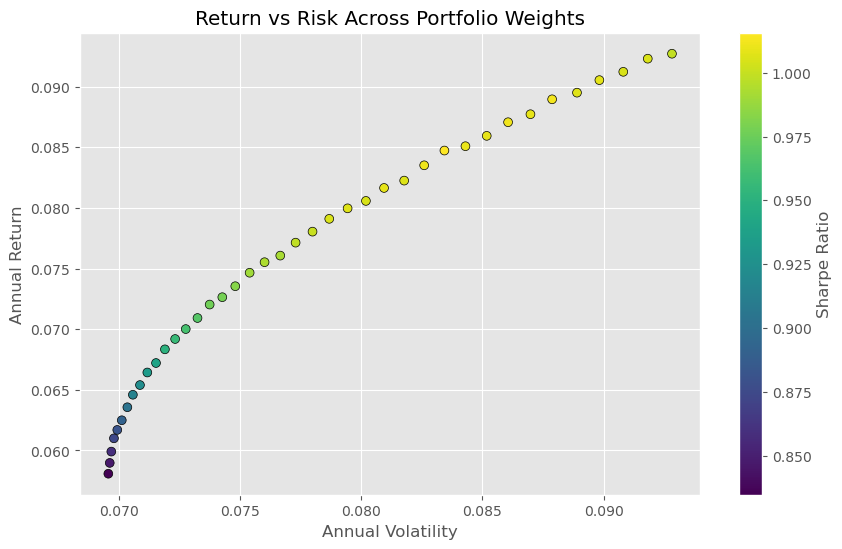

In [23]:
plot_risk_return(results_df)

#### 6. Choosing the Final Strategy.

After reviewing all the analyses, I found that one strategy meets my performance goals using a portfolio made up of four assets: `['ITPS', 'EM710', 'CSSPX', 'PHAU']`. The key details of this strategy are:

- A minimum starting capital of 105,000.
- Asset allocation: 34% in CSSPX and 22% in each of the other three.
- Rebalancing the portfolio once a year (every 252 trading days).

Next, I test this specific setup using the `backtest_sim()` function and review the performance metrics to confirm its effectiveness.

In [24]:
initial_capital = 105_000
initial_weights = np.array([0.22, 0.22, 0.34, 0.22])
rebalance_frequency = 252

_, portfolio_values = backtest_sim(ticker_prices=portfolio_prices,
                                   initial_capital=initial_capital,
                                   initial_weights=initial_weights,
                                   rebalance_frequency=rebalance_frequency)

105000 Euros invested in this strategy would be worth 320255.65 Euros today


<Axes: title={'center': 'Portfolio Values over time'}, xlabel='Date', ylabel='Portfolio Value'>

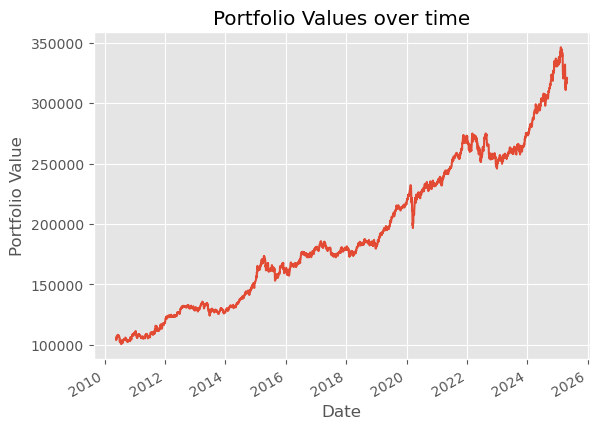

In [25]:
print(f'{initial_capital} Euros invested in this strategy would be worth',
      portfolio_values.iloc[-1].round(2), 'Euros today')
portfolio_values.plot(title='Portfolio Values over time', ylabel='Portfolio Value')

In [26]:
print('Backtest length: ', 
      round((portfolio_values.index[-1] - portfolio_values.index[0]) / pd.to_timedelta('365.25D'), 2), 'years \n')
print('Total Return:', round(portfolio_performance(portfolio_values).Total_Return*100,2), '%')
print('Annual Return:', round(portfolio_performance(portfolio_values).Annual_Return*100,2), '%')
print('Annual Volatility:', round(portfolio_performance(portfolio_values).Annual_Volatility*100,2), '%')
print('Sharpe Ratio:', round(portfolio_performance(portfolio_values).Sharpe,3))

Backtest length:  14.93 years 

Total Return: 205.15 %
Annual Return: 7.76 %
Annual Volatility: 7.74 %
Sharpe Ratio: 1.002


In [27]:
print('10 Worst Drawdowns of this strategy: \n')
drawdowns = drawdown_metrics(portfolio_values)
drawdowns['duration'] = drawdowns['valley'] - drawdowns['start']
drawdowns['recovery_time'] = drawdowns['end'] - drawdowns['valley']
drawdowns['total_lenght'] = drawdowns['end'] - drawdowns['start']
drawdowns

10 Worst Drawdowns of this strategy: 



,drawdown,start,valley,end,duration,recovery_time,total_lenght
0,-0.153039,2020-02-20,2020-03-18,2020-08-07,27 days,142 days,169 days
1,-0.116624,2015-04-16,2015-08-24,2016-07-01,130 days,312 days,442 days
2,-0.105780,2022-08-17,2022-12-30,2023-12-15,135 days,350 days,485 days
3,-0.102170,2025-02-11,2025-04-09,NaT,57 days,NaT,NaT
4,-0.085511,2022-03-09,2022-06-16,2022-08-16,99 days,61 days,160 days
5,-0.085188,2013-03-28,2013-06-24,2014-06-10,88 days,351 days,439 days
6,-0.072217,2017-03-03,2017-08-29,2018-08-10,179 days,346 days,525 days
7,-0.070400,2010-06-08,2010-07-19,2010-11-30,41 days,134 days,175 days
8,-0.057949,2011-01-12,2011-04-12,2011-08-31,90 days,141 days,231 days
9,-0.051395,2021-11-22,2022-02-04,2022-03-04,74 days,28 days,102 days


### Summary
In this chapter, I applied the functions and tools developed earlier (available in the `Utils.py` file) to test an investment strategy based on a portfolio of four assets.

I started by backtesting each asset individually. Then, I explored different asset weight combinations to find those that met my performance criteria — specifically, a Sharpe Ratio greater than 1 and a maximum drawdown between -14.5% and -15.5% — using the `backtest_portfolio()` function for both *annual rebalancing* (every 252 trading days) and a *buy-and-hold* approach.

To refine the analysis, I used the `backtest_vect()` function — a faster, vectorized backtesting method — to determine the minimum initial capital needed for at least one portfolio to meet my criteria.
Finally, I validated the selected strategy by simulating it with the `backtest_sim()` function and analyzing its performance metrics.

**Note:**
- The `backtest_portfolio()` function is particularly useful for a quick preliminary analysis of portfolio strategies, helping to suggest reasonable asset weights and whether periodic rebalancing improves performance.
- The `backtest_vect()` function provides a more precise fine-tuning step, allowing efficient testing to find the minimum initial capital needed to achieve the desired portfolio performance before making a final decision.